In [1]:
import math
import numpy as np
import string
from datetime import datetime
import sys
import os
from astropy.table import Table
import random
import glob

import matplotlib.pyplot as plt;
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
import seaborn as sns;
from scipy import stats
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

np.random.seed(12)

# import SetPub
# SetPub.set_pub()


# https://github.com/dunovank/jupyter-themes
# jt -t onedork -fs 14 -altp -tfs 14 -nfs 14 -ofs 14 -cellw 90% -T -N -kl

# # import jtplot submodule from jupyterthemes
# from jupyterthemes import jtplot

# # currently installed theme will be used to
# # set plot style if no arguments provided
# jtplot.style()

In [2]:
print(20*'=~')
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
print(20*'=~')

=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~
=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~


In [3]:
def ReadGalaxPy(path_program = '../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = True):    
    class Curated_sample():
        ''' Class to store the redshift and colors of observed galaxies,
            and the redshift, Mpeak, colors, and "weights" of simulated
            galaxies whose colors are compatible with those of observed
            galaxies.

            The observed sample include galaxies from SDSS
            (SDSS+BOSS+eBOSS), DEEP2, and VIPERS.

            The simulated sample was created by sampling the parameter of
            GALAXPY using a LH.

            The weights of simulated galaxies are related to the number
            density of observed galaxies in the same region of the color
            space.

            You only have to care about the method load_structure. '''

        def __init__(self):
            self.arr_c = []
            self.arr_z = []
            self.arr_m = []
            self.arr_w = []

        def append(self, c, z, m, w):
            self.arr_c.append(c)
            self.arr_z.append(z)
            self.arr_m.append(m)
            self.arr_w.append(w)

        def ndarray(self):
            self.arr_c = np.concatenate(self.arr_c)
            self.arr_z = np.concatenate(self.arr_z)
            self.arr_m = np.concatenate(self.arr_m)
            self.arr_w = np.concatenate(self.arr_w)

        def save_struct(self, name):
            np.save(name + 'c.npy', self.arr_c)
            np.save(name + 'z.npy', self.arr_z)
            np.save(name + 'm.npy', self.arr_m)
            np.save(name + 'w.npy', self.arr_w)

        def load_struct(self, name):
            self.arr_c = np.load(name + 'c.npy')
            self.arr_z = np.load(name + 'z.npy')
            self.arr_m = np.load(name + 'm.npy')
            self.arr_w = np.load(name + 'w.npy')

        def duplicate_data(self, zrange):
            aa = np.where((self.arr_w > 50)
                          & (self.arr_z >= zrange[0])
                          & (self.arr_z < zrange[1]))[0]
            print(aa.shape)
            cc = np.repeat(aa, self.arr_w[aa].astype(int))
            self.arr_cn = self.arr_c[cc, :]
            self.arr_zn = self.arr_z[cc]
            self.arr_mn = self.arr_m[cc]


    def read_curated_data():
        run_path = path_program + 'runs/run_z3/'

        sim_q = Curated_sample()  # simulated colors quenched galaxies
        sim_s = Curated_sample()  # simulated colors star-forming galaxies
        obs_q = Curated_sample()  # observed colors quenched galaxies
        obs_s = Curated_sample()  # observed colors star-forming galaxies

        obs_q.load_struct(run_path + 'str_obs_q')
        obs_s.load_struct(run_path + 'str_obs_s')
        sim_q.load_struct(run_path + 'str_sim_q')
        sim_s.load_struct(run_path + 'str_sim_s')

        print(sim_q.arr_c.shape)
        print(sim_s.arr_c.shape)
        print(obs_q.arr_c.shape)
        print(obs_s.arr_c.shape)

        return sim_q, sim_s, obs_q, obs_s


    sim_q, sim_s, obs_q, obs_s = read_curated_data()

    if sim_obs_combine:
        train_datafile = 'GalaxPy'

        # 2.0 ####### TRAIN USING SIMULATION, TEST OBSERVATION ####

        Trainfiles = np.append(sim_q.arr_c, sim_s.arr_c, axis=0)
        TrainZ = np.append(sim_q.arr_z, sim_s.arr_z, axis=0)

        Trainfiles = np.delete(Trainfiles, (4), axis=1)  ## deleting z-Y

        Testfiles = np.append(obs_q.arr_c, obs_s.arr_c, axis=0)
        TestZ = np.append(obs_q.arr_z, obs_s.arr_z, axis=0)

        TrainshuffleOrder = np.arange(Trainfiles.shape[0])
        np.random.shuffle(TrainshuffleOrder)

        Trainfiles = Trainfiles[TrainshuffleOrder]
        TrainZ = TrainZ[TrainshuffleOrder]

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]
        TestZ = TestZ[TestshuffleOrder]

        # X_train = Trainfiles[:num_train]  # color mag
        # X_test = Trainfiles[:num_test]  # color mag

        # y_train = TrainZ[:num_train]  # spec z
        # y_test = TrainZ[:num_test]  # spec z

        #### THIS PART WAS WRONG above --- incorrect test and train -- BOTH WERE SAME ####

        X_train = Trainfiles[:num_train]  # color mag
        X_test = Testfiles[:num_test]  # color mag

        y_train = TrainZ[:num_train]  # spec z
        y_test = TestZ[:num_test]  # spec z

    else:
        train_datafile = 'SDSS'
        # 1.1 ####### SIMULATED: QUENCHED ONLY ############
        # Trainfiles = sim_q.arr_c
        # TrainZ = sim_q.arr_z

        # 1.2 ### SIMULATED: QUENCHED + STAR FORMATION ####

        # Trainfiles =np.append( sim_q.arr_c, sim_s.arr_c, axis = 0)
        # TrainZ = np.append( sim_q.arr_z, sim_s.arr_z, axis = 0)

        # 1.3 ####### OBSERVED: QUENCHED + STAR FORMATION ####

        Trainfiles = np.append(obs_q.arr_c, obs_s.arr_c, axis=0)
        TrainZ = np.append(obs_q.arr_z, obs_s.arr_z, axis=0)

        TrainshuffleOrder = np.arange(Trainfiles.shape[0])
        np.random.shuffle(TrainshuffleOrder)

        Trainfiles = Trainfiles[TrainshuffleOrder]
        TrainZ = TrainZ[TrainshuffleOrder]

        # 1 #################################

        X_train = Trainfiles[:num_train]  # color mag
        X_test = Trainfiles[num_train + 1: num_train + num_test]  # color mag

        X_train = Trainfiles[:num_train]  # color mag
        X_test = Trainfiles[num_train + 1: num_train + num_test]  # color mag

        y_train = TrainZ[:num_train]  # spec z
        y_test = TrainZ[num_train + 1: num_train + num_test]  # spec z

    ############## THINGS ARE SAME AFTER THIS ###########


    if logTrue:
        y_test = np.log10(y_test)
        y_train = np.log10(y_train)

    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin

In [4]:

def ReadCosmosDraw_UM(path_program = '../../Data/fromGalaxev/photozs/datasets/'):
    np.random.seed(12211)  
    fileIn = path_program + 'Training_data_UM_random/all_finite_col_mag_sdss.npy'
    #fileInColors = path_program + 'new_cosmos_sdss/all_col_sdss.npy'

    TrainfilesColors = np.load(fileIn)
    #TrainfilesMagI = np.load(fileInMagI)
    print('Train files shape', TrainfilesColors.shape)

    min_col = -5
    max_col = 5
    max_max = 25
    for ii in range(TrainfilesColors.shape[1]):
        aa = np.alltrue(np.isfinite(TrainfilesColors[:, ii, :]), axis=1)
        bb = (TrainfilesColors[:,ii,-1] < max_max) & (aa == True)
        cc = np.alltrue(TrainfilesColors[:, ii, :-1] < max_col, axis=1) & (bb == True)
        mask = np.alltrue(TrainfilesColors[:, ii, :-1] > min_col, axis=1)  & (cc == True)

    TrainfilesColors = TrainfilesColors[mask]
    print(TrainfilesColors.shape)


    #magI_low = 15
    #magI_high = 23

    fileInZ = path_program + 'Training_data_UM_random/redshifts.npy'
    TrainZ = np.load(fileInZ)

    # print(TrainfilesCol.shape, TrainZ.shape)
    
    # Trainfiles = np.append(TrainfilesCol, TrainZ[:, None], axis=1) 

    Trainfiles = np.zeros(shape=(TrainfilesColors.shape[0]*TrainfilesColors.shape[1], TrainfilesColors.shape[2] + 1))

    for galID in range(TrainfilesColors.shape[0]):

    #     TrainfilesMagI[galID, :, 1][TrainfilesMagI[galID, :, 1] < magI_low] = magI_low
    #     TrainfilesMagI[galID, :, 0][TrainfilesMagI[galID, :, 0] > magI_high] = magI_high

    #     imag = np.random.uniform(low=TrainfilesMagI[galID, :, 0], high=TrainfilesMagI[galID, :, 1], size=(num_magI_draws, np.shape(TrainfilesMagI[galID, :, 1])[0])).T

        # for mag_degen in range(num_magI_draws):
            # colors_mag = np.append(TrainfilesColors[galID, :, :], imag[:, mag_degen][:, None], axis=1)
            trainfiles100 = np.append(TrainfilesColors[galID, :, :] , TrainZ[:, None], axis=1)

            train_ind_start = galID*TrainfilesColors.shape[1]
            train_ind_end = galID*TrainfilesColors.shape[1] + TrainfilesColors.shape[1]

            # print(train_ind_start, train_ind_end)

            Trainfiles[train_ind_start: train_ind_end] = trainfiles100

    print('Train files shape (with z)', Trainfiles.shape)


    TrainshuffleOrder = np.arange(Trainfiles.shape[0])
    np.random.shuffle(TrainshuffleOrder)
    Trainfiles = Trainfiles[TrainshuffleOrder]

    Test_VAL = False  ## -- doesn't work
    if Test_VAL: 

        fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        Testfiles = np.load(fileIn)
        print('Test files shape:', Testfiles.shape)


        # min_col = -5
        # max_col = 5
        # max_max = 25
        # for ii in range(Testfiles.shape[1]):
        #     aa = np.alltrue(np.isfinite(Testfiles[:, ii, :]), axis=1)
        #     bb = (Testfiles[:,ii,-1] < max_max) & (aa == True)
        #     cc = np.alltrue(Testfiles[:, ii, :-1] < max_col, axis=1) & (bb == True)
        #     mask = np.alltrue(Testfiles[:, ii, :-1] > min_col, axis=1)  & (cc == True)


        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]
        X_train = Trainfiles[:num_train, :-1]  # color mag
        X_test = Testfiles[:num_test, 1:]  # color mag
        
        y_train = Trainfiles[:num_train, -1]  # spec z
        y_test = Testfiles[:num_test, 0] # spec z

    # ############## THINGS ARE SAME AFTER THIS ###########
    #
    # ## rescaling xmax/xmin
    # xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    # xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)
    #
    # X_train = (X_train - xmin) / (xmax - xmin)
    # X_test = (X_test - xmin) / (xmax - xmin)
    #
    # #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue
    #
    # ymax = np.max([y_train.max(), y_test.max()])
    # ymin = np.min([y_train.min(), y_test.min()])
    #
    # y_train = (y_train - ymin) / (ymax - ymin)
    # y_test = (y_test - ymin) / (ymax - ymin)
    #
    # return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin
    #
    # ############# THINGS ARE SAME AFTER THIS ###########

    TestSynth = False

    if TestSynth:

        X_train = Trainfiles[:num_train, :-1]  # color mag
        X_test = Trainfiles[num_train + 1: num_train + num_test, :-1]  # color mag


        y_train = Trainfiles[:num_train, -1]   # spec z
        y_test = Trainfiles[num_train + 1: num_train + num_test, -1]  # spec z


    ##################################################
    ##################################################

    TestSDSS = False  ## Dont use this one -- it's not really SDSS
    if TestSDSS:

        #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        fileIn = path_program + 'Data_from_observations_new/SDSS_cols.npy'
        TestfilesColors = np.load(fileIn)
        fileIn = path_program + 'Data_from_observations_new/SDSS_iband.npy'
        TestfilesMag = np.load(fileIn)   
        
        Testfiles = np.append(TestfilesColors, TestfilesMag[:, None], axis=1)


        # TrainshuffleOrder = np.arange(Trainfiles.shape[0])
        # np.random.shuffle(TrainshuffleOrder)

        # Trainfiles = Trainfiles[TrainshuffleOrder]

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]

        X_train = Trainfiles[:num_train, :-1]  # color mag
        X_test = Testfiles[:num_test, 1:]  # color mag
        y_train = Trainfiles[:num_train, -1]  # spec z
        y_test = Testfiles[:num_test, 0] # spec z

    TestSDSS_2 = True
    if TestSDSS_2:

        #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        fileIn_col = path_program + 'Training_data_UM_random/SDSS_col_val.npy'
        fileIn_z = path_program + 'Training_data_UM_random/SDSS_zz_val.npy'
        
        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)
  
        
        Testfiles = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]

        X_train = Trainfiles[:num_train, :-1]  # color mag
        X_test = Testfiles[:num_test, 1:]  # color mag
        y_train = Trainfiles[:num_train, -1]  # spec z
        y_test = Testfiles[:num_test, 0] # spec z
    ############################################################
    ############## THINGS ARE SAME AFTER THIS ###########

    if logTrue:
        y_test = np.log10(y_test)
        y_train = np.log10(y_train)


    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin

In [5]:

def ReadSDSS(path_program = '../../Data/fromGalaxev/photozs/datasets/'):
    np.random.seed(12211)  

    TestSDSS_2 = True
    if TestSDSS_2:

        #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        fileIn_col = path_program + 'Training_data_UM_random/SDSS_col_val.npy'
        fileIn_z = path_program + 'Training_data_UM_random/SDSS_zz_val.npy'
        
        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)

        print('number of SDSS datapoints', str(Testfiles_z.shape[0]))
  
        
        Testfiles = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]

        X_train = Testfiles[:num_train, :-1]  # color mag
        X_test = Testfiles[num_train + 1:num_train + num_test, 1:]  # color mag
        y_train = Testfiles[:num_train, -1]  # spec z
        y_test = Testfiles[num_train + 1:num_train + num_test, 0] # spec z
    ############################################################
    ############## THINGS ARE SAME AFTER THIS ###########

    if logTrue:
        y_test = np.log10(y_test)
        y_train = np.log10(y_train)


    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin

In [6]:
############training

logTrue = False

GalaxPyTrue = False

if GalaxPyTrue: 

    Trainset = 'GalaxyPy'

    num_train = 12000000 #800000
    num_test = 20000 #5000 #params.num_test # 32
    syntheticTrain = True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

    #### X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadGalaxPy(path_program = '../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = syntheticTrain)
    X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadGalaxPy(path_program = '../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = syntheticTrain)

ObservedTrainTrue = False


if ObservedTrainTrue:

    Trainset = 'Obs'

    num_train = 800000 #2900000 #000#00 #800000 #12000000 #800000
    num_test = 20000 #5000 #params.num_test # 32
    syntheticTrain = True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

    X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadSDSS(path_program = '../../Data/fromGalaxev/photozs/datasets/')


UMTrue = True

if UMTrue:

    Trainset = 'UM'

    num_train = 1000000 #2900000 #000#00 #800000 #12000000 #800000
    num_test = 20000 #5000 #params.num_test # 32
    syntheticTrain = True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

    X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadCosmosDraw_UM(path_program = '../../Data/fromGalaxev/photozs/datasets/')


print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))



Train files shape (29066, 100, 5)
(11333, 100, 5)
Train files shape (with z) (1133300, 6)
Size of features in training data: (1000000, 5)
Size of output in training data: (1000000,)
Size of features in test data: (20000, 5)
Size of output in test data: (20000,)


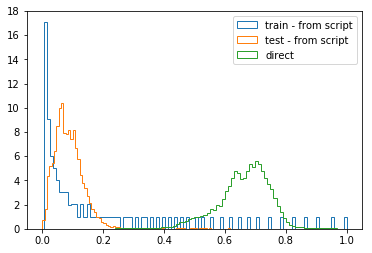

In [7]:
plt.figure(23)
# y_t = 10**(ymax - ymin)*(ymin + y_test)
y_t =  y_test
y_tr =  y_train

z_load = '../../Data/fromGalaxev/photozs/datasets/'+ 'Training_data_UM_random/SDSS_zz_val.npy'
y_f = np.load(z_load)
y_f = np.log10( y_f )
y_f = (y_f - y_f.min())/(y_f.max() - y_f.min())
plt.hist(y_tr, normed=True, bins = 100, histtype='step', label='train - from script')
plt.hist(y_t, normed=True, bins = 100, histtype='step', label='test - from script')
plt.hist(y_f, normed=True, bins = 100, histtype='step', label='direct')
plt.legend()

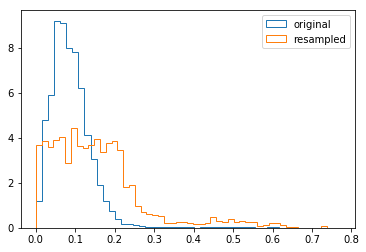

In [8]:
reSampleTest = True
if reSampleTest :
    # test_argsort = np.argsort(y_test)
    # y_test = y_test[test_argsort]
    # X_test = X_test[test_argsort]

    num_y_test_select_per_bin = 100
    n_bins = 50
    np.random.seed(1)

    bins = np.linspace(y_test.min(), y_test.max(), n_bins)
    # bins = np.logspace(np.log10(y_test.min()+1e-2), np.log10(y_test.max()+1e-2), n_bins)
    inds = np.digitize(y_test, bins)

    # print(bins)
    # print(inds.shape, inds.max())
    # hist_y = np.histogram(y_test, bins = bins)
    # plt.plot(inds)
    # plt.plot(hist_y[0], '-.')
    # plt.yscale('log')

    resampled_ind = []

    for ind_i in range(n_bins):
        ind_bin = np.where(inds==ind_i)
        random_choices = np.min( [num_y_test_select_per_bin, np.size(ind_bin) ])
        index = np.random.choice(ind_bin[0], random_choices, replace=False)
        resampled_ind = np.append(resampled_ind, index)

    resampled_ind = resampled_ind.astype('int')


    plt.figure(23)
    plt.hist(y_test, normed=True, bins = 50, histtype='step', label='original')
    y_test1 = y_test[resampled_ind]
    X_test1 = X_test[resampled_ind]

    plt.hist(y_test1, normed=True, bins = 50, histtype='step', label='resampled')
    plt.legend()
    plt.show()

    # print(int_select)




In [9]:
if reSampleTest :
    y_test = y_test1
    X_test = X_test1

In [10]:
PairPlotTrue = False

if PairPlotTrue:
    import seaborn as sns
    import pandas as pd
    from IPython.display import Image

    ############ loading data ############
    # num_train = 800000

    # _, _, X_test, y_test, ymax, ymin, xmax, xmin = ReadGalaxPy(path_program = '../../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = False)

    # print("Size of features in training data: {}".format(X_train.shape))
    # print("Size of output in training data: {}".format(y_train.shape))
    # print("Size of features in test data: {}".format(X_test.shape))
    # print("Size of output in test data: {}".format(y_test.shape))

    num_data = 2000

    df_train = pd.DataFrame()

    # Add columns
    df_train['u-g'] = X_train[:num_data, 0]
    df_train['g-r'] = X_train[:num_data, 1]
    df_train['r-i'] = X_train[:num_data, 2]
    df_train['i-z'] = X_train[:num_data, 3]
    df_train['mag(i)'] = X_train[:num_data, 4]
    df_train['redshift'] = y_train[:num_data]


    df_test = pd.DataFrame()

    # Add columns
    df_test['u-g'] = X_test[:num_data, 0]
    df_test['g-r'] = X_test[:num_data, 1]
    df_test['r-i'] = X_test[:num_data, 2]
    df_test['i-z'] = X_test[:num_data, 3]
    df_test['mag(i)'] = X_test[:num_data, 4]
    df_test['redshift'] = y_test[:num_data]


    df_all = pd.concat([df_train.assign(dataset='train'), df_test.assign(dataset='test')])


    #### plotting ####
    g = sns.PairGrid(df_all, hue='dataset')
    g = g.map_upper(sns.scatterplot, alpha=0.8)
    g = g.map_lower(sns.kdeplot, n_levels=6, shade=True, shade_lowest=False, alpha=0.7)
    g = g.map_diag(sns.kdeplot, lw=2, shade=True)
    # g = g.map_diag(sns.distplot, hist=True, kde=False)
    g = g.add_legend()

    g.savefig("pairplot_best.png")

    plt.clf() # Clean parirplot figure from sns 
    Image(filename='pairplot_best.png') # Show pairplot as image



In [11]:
print(tf.__version__)

1.14.0


In [12]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)


def neural_network_mod():
    """
    loc, scale, logits = NN(x; theta)

    Args:
      X: Input Tensor containing input data for the MDN
    Returns:
      locs: The means of the normal distributions that our data is divided into.
      scales: The scales of the normal distributions that our data is divided
        into.
      logits: The probabilities of ou categorical distribution that decides
        which normal distribution our data points most probably belong to.
    """
    # X = tf.placeholder(tf.float64,name='X',shape=(None,D))
    # # 2 hidden layers with 15 hidden units
    # net = tf.layers.dense(X, 32, activation=tf.nn.relu)
    # net = tf.layers.dense(net, 16, activation=tf.nn.relu)
    # net = tf.layers.dense(net, 8, activation=tf.nn.relu)
    # locs = tf.layers.dense(net, K, activation=None)
    # scales = tf.layers.dense(net, K, activation=tf.exp)
    # logits = tf.layers.dense(net, K, activation=None)
    # outdict= {'locs':locs, 'scales':scales, 'logits':logits}
    # hub.add_signature(inputs=X,outputs=outdict)

    # return locs, scales, logits


    X = tf.placeholder(tf.float64,name='X',shape=(None,D))
    # 2 hidden layers with 15 hidden units
    net = tf.layers.dense(X, 128, activation=tf.nn.relu)
    net = tf.layers.dense(net, 64, activation=tf.nn.relu)
    net = tf.layers.dense(net, 32, activation=tf.nn.relu)
    locs = tf.layers.dense(net, K, activation=None)
    scales = tf.layers.dense(net, K, activation=tf.exp)
    logits = tf.layers.dense(net, K, activation=None)
    outdict= {'locs':locs, 'scales':scales, 'logits':logits}
    hub.add_signature(inputs=X,outputs=outdict)

    return locs, scales, logits


def mixture_model(X,Y,learning_rate=1e-3,decay_rate=.95,step=1000,train=True):
    if train:
        dict = neural_network(tf.convert_to_tensor(X),as_dict=True)
    else:
        dict = neural_network_t(tf.convert_to_tensor(X),as_dict=True)
    locs = dict['locs'] ; scales = dict['scales'] ; logits = dict['logits']
    cat = tfd.Categorical(logits=logits)
    components = [tfd.Normal(loc=loc, scale=scale) for loc, scale
                  in zip(tf.unstack(tf.transpose(locs)),
                         tf.unstack(tf.transpose(scales)))]

    y = tfd.Mixture(cat=cat, components=components)
    #define loss function
    log_likelihood = y.log_prob(Y)
    # log_likelihood = -tf.reduce_sum(log_likelihood/(1. + y_train)**2 )
    y_mean = np.median(Y)
    log_likelihood = -tf.reduce_sum(log_likelihood)
    #log_likelihood = -tf.reduce_sum(log_likelihood*(y_mean-y_train)**4 )
    if train:
        global_step = tf.Variable(0, trainable=False)
        decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, step,
                                        decay_rate, staircase=True)
        optimizer = tf.train.AdamOptimizer(decayed_lr)
        train_op = optimizer.minimize(log_likelihood)
        evaluate(tf.global_variables_initializer())
        return log_likelihood, train_op, logits, locs, scales
    else:
        evaluate(tf.global_variables_initializer())
        return log_likelihood, logits, locs, scales

def train(log_likelihood,train_op,n_epoch):
    train_loss = np.zeros(n_epoch)
    test_loss = np.zeros(n_epoch)
    for i in range(n_epoch):
        _, loss_value = evaluate([train_op, log_likelihood])
        train_loss[i] = loss_value
    plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train Loss')
    # plt.savefig('../Plots/T_loss_function.pdf')
    return train_loss

def get_predictions(logits,locs,scales):
    pred_weights, pred_means, pred_std = evaluate([tf.nn.softmax(logits), locs, scales])
    return pred_weights, pred_means, pred_std

def testing(X_test,y_test):

    log_likelihood,  logits, locs, scales = mixture_model(X_test,y_test,train=False)
    #_, loss_value = evaluate([train_op, log_likelihood])
    pred_weights, pred_means, pred_std = get_predictions(logits,locs,scales)
    return pred_weights, pred_means, pred_std

In [13]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """
  # x = np.linspace(-10.5, 10.5, 250)
  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
      ax.plot(x, temp, label='Normal ' + str(i), alpha =0.3)
  ax.plot(x, final, label='Mixture of Normals ' + label)
  ax.legend(fontsize=13)
  return final

def plot_pdfs(pred_means,pred_weights,pred_std, y,num=4, train=True):
    np.random.seed(12)
#     np.random.seed(12)

#     if train:
#         obj = [random.randint(0,num_train-1) for x in range(num)]
#     else:
#         obj = [random.randint(0,num_test-1) for x in range(num)]
#     #obj = [93, 402, 120,789,231,4,985]
    if train:
        obj = np.random.randint(0,num_train-1,num)
    else:
        obj = np.random.randint(0,num_test-1,num)
    #obj = [93, 402, 120,789,231,4,985]
    
    print(obj)
#     fig, axes = plt.subplots(nrows=num, ncols=1, sharex = True, figsize=(8, 7), num='PDFs')
    allfs = []
    for i in range(len(obj)):
        fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i],
                    pred_std[obj][i], axes[i], comp=False)
        allfs.append(fs)
        axes[i].axvline(x=y[obj][i], color='black', alpha=0.5)
#         axes[i].text(0.3, 4.0, 'ID: ' +str(obj[i]), horizontalalignment='center', verticalalignment='center')

#     plt.xlabel(r' rescaled[$z_{pred}]$', fontsize = 19)
    plt.xlabel(r'$z_{\rm pred}]$', fontsize = 22)
    plt.ylabel('$PDF$', fontsize = 22)


    # plt.savefig('../Plots/T_pdfs.pdf')
#     plt.show()

def plot_pred_mean(pred_means,pred_weights,pred_std,ymax,ymin,y,select='no'):
    y_pred = np.sum(pred_means*pred_weights, axis = 1)
    y_pred_std = np.sum(pred_std*pred_weights, axis = 1)

    plt.figure(22, figsize=(9,8))

    #ymax=1
    #ymin=0
    # if select == 'yes':
    #     y_pred = y_pred[obj]
    #     y_train = y_train[obj]
    #     y_pred_std = y_pred_std[obj]

    # plt.scatter(y_test, y_pred, facecolors='k', s = 1)

    # plt.errorbar( (ymax - ymin)*(y_train)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    plt.errorbar( (ymax - ymin)*(y)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(y_pred_std), fmt='o', ms = 2, alpha = 0.1)

    #switched
    #plt.errorbar(  (ymax - ymin)*(y_pred)+ymin, (ymax - ymin)*(y_train)+ymin, yerr= (ymax - ymin)*(y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

    #plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
    plt.plot((ymax - ymin)*(y)+ymin, (ymax - ymin)*( y)+ymin, 'k')

    plt.ylabel(r'$z_{pred}$', fontsize = 19)
    plt.xlabel(r'$z_{true}$', fontsize = 19)
    #plt.xlim([0,1])
    #plt.ylim([0,1])
    plt.title('weight x mean')
    plt.tight_layout()
    # plt.savefig('../Plots/T_pred_mean.pdf')
#     plt.show()

def plot_pred_peak(pred_means,pred_weights,pred_std,ymax,ymin,y,select='no'):
    def peak(weight,sigma):
        return weight/np.sqrt(2*np.pi*sigma**2)

    peak_max = np.argmax(peak(pred_weights,pred_std),axis=1)
    y_pred = np.array([pred_means[i,peak_max[i]] for i in range(len(y))])
    y_pred_std = np.array([pred_std[i,peak_max[i]] for i in range(len(y))])
    plt.figure(24, figsize=(9, 8))
    # if select == 'yes':
    #     y_pred = y_pred[obj]
    #     y_train = y_train[obj]
    #     y_pred_std = y_pred_std[obj]
    # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
    # plt.errorbar((ymax - ymin)*(y_train)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(
    #   y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

    plt.errorbar((ymax - ymin)*(y)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(
      y_pred_std), fmt='o', ms = 2, alpha = 0.1)


    #plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
    plt.plot((ymax - ymin)*(y_test)+ymin, (ymax - ymin)*(y_test)+ymin, 'k')
    plt.ylabel(r'$z_{pred}$', fontsize = 19)
    plt.xlabel(r'$z_{true}$', fontsize = 19)
    #plt.xlim([0,1])
    #plt.ylim([0,1])
    plt.title('highest peak')
    plt.tight_layout()
#     plt.show()

def plot_pred_weight(pred_means,pred_weights,pred_std,ymax,ymin,y,select='no'):
    weight_max = np.argmax(pred_weights, axis = 1)  ## argmax or max???

    y_pred = np.array([pred_means[i,weight_max[i]] for i in range(len(y))])
    y_pred_std = np.array([pred_std[i,weight_max[i]] for i in range(len(y))])

    plt.figure(29, figsize=(9, 8))
    # if select == 'yes':
    #     y_pred = y_pred[obj]
    #     y_train = y_train[obj]
    #     y_pred_std = y_pred_std[obj]

    # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
    # plt.errorbar((ymax - ymin)*(y_train)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(
    #   y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

    plt.errorbar((ymax - ymin)*(y)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(
      y_pred_std), fmt='o', ms = 2, alpha = 0.1)

    #plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
    plt.plot((ymax - ymin)*(y_test)+ymin, (ymax - ymin)*(y_test)+ymin, 'k')
    plt.ylabel(r'$z_{pred}$', fontsize = 19)
    plt.xlabel(r'$z_{true}$', fontsize = 19)
    #plt.xlim([0,1])
    #plt.ylim([0,1])
    plt.title('highest weight')
    plt.tight_layout()
#     plt.show()


def per_stats(pred_means,pred_weights,pred_std,ymax,ymin,y):
    y_pred = np.sum(pred_means*pred_weights, axis = 1)
    y_pred_std = np.sum(pred_std*pred_weights, axis = 1)
    y_pred = (ymax - ymin)*(y_pred)+ymin
    y_pred_std = (ymax - ymin)*(y_pred_std)
    y = (ymax - ymin)*(y)+ymin
    diff = y_pred-y
    mean_diff = np.mean(diff)
    med_diff = np.median(diff)
    std_diff = np.std(diff)
    mean_sigma = np.mean(y_pred_std)
    med_sigma = np.median(y_pred_std)
    std_sigma = np.std(y_pred_std)
    return mean_diff, med_diff, std_diff, mean_sigma, med_sigma, std_sigma

def plot_cum_sigma(pred_weights,pred_std,ymax,ymin):
    #y_pred_std = np.sum(pred_std*pred_weights, axis = 1)

    weight_max = np.argmax(pred_weights, axis = 1)  ## argmax or max???
    y_pred_std = np.array( [pred_std[i,weight_max[i] ] for i in range(len(pred_weights[0]))])
    y_pred_std = (ymax - ymin)*(y_pred_std)
    plt.figure(222)
    plt.hist(y_pred_std,1000, density=True, histtype='step', cumulative=True)
    plt.xlabel('Sigma')
#     plt.show()

In [14]:
# n_epochs = 40000 #3030030 #000 #20000 #100000 #1000 #20000 #20000
# # N = 4000  # number of data points  -- replaced by num_trai
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3 # number of mixture components


# learning_rate = 1e-3
# decay_rate= 0.01 #0.0
# step=1000


In [15]:
n_epochs = 1000
D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K = 16 # number of mixture components


learning_rate = 5e-3
decay_rate= 0.1 #0.0
step=10

In [16]:

syntheticTrain = True # True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

save_mod = './saved_hubs/'+'sdss_colmagUM_synthetic_'+str(syntheticTrain)+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)



In [17]:
save_mod# --- synthetic 1 mil run

'./saved_hubs/sdss_colmagUM_synthetic_True_lr_0.005_dr0.1_step10_ne1000_k16_nt1000000'

==================== training complete====================


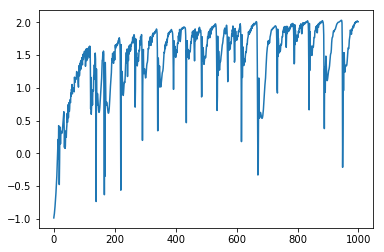

In [18]:
train_mode = True

if train_mode:

    net_spec = hub.create_module_spec(neural_network_mod)
    neural_network = hub.Module(net_spec,name='neural_network',trainable=True)

    log_likelihood, train_op, logits, locs, scales  = mixture_model(X_train,y_train,learning_rate=learning_rate,decay_rate=decay_rate)

    train_loss = train(log_likelihood,train_op,n_epochs)



    #save network
    neural_network.export(save_mod,sess)
    print(20*'=' + ' training complete' + 20*'=' )

    train_plots = False
    if train_plots:
        pred_weights, pred_means, pred_std = get_predictions(logits, locs, scales)
        print(pred_means)

        # plot_pdfs(pred_means,pred_weights,pred_std)

        plot_pred_mean(pred_means,pred_weights,pred_std,ymax,ymin,y_train)

        mean_diff, med_diff, std_diff, mean_sigma, med_sigma, std_sigma = per_stats(pred_means,pred_weights,pred_std,ymax,ymin,y_train)

        plot_cum_sigma(pred_weights,pred_std,ymax,ymin)


        plot_pred_peak(pred_means,pred_weights,pred_std,ymax,ymin,y_train)
        plot_pred_weight(pred_means,pred_weights,pred_std,ymax,ymin,y_train)

    print(20*'=')



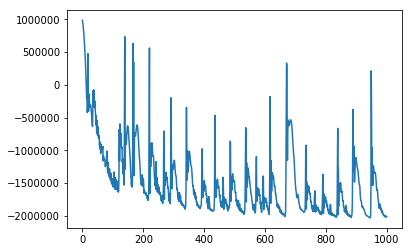

In [19]:
if train_mode:

    plt.figure(1222)
    plt.plot(train_loss)
    plt.savefig(save_mod + '/loss.png')
    plt.show()

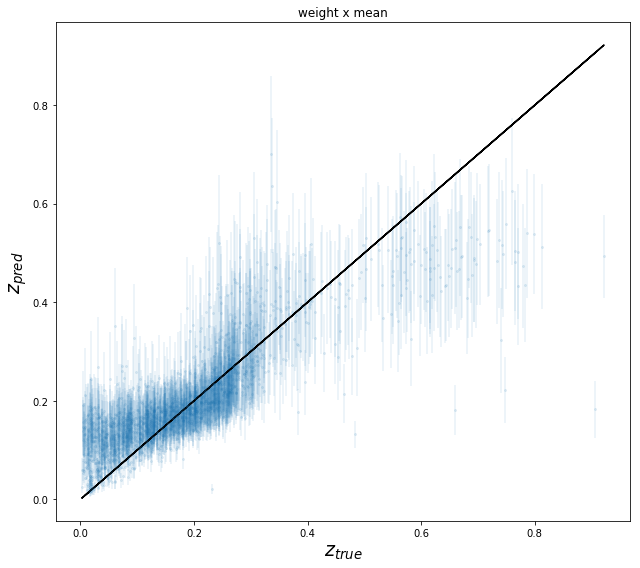

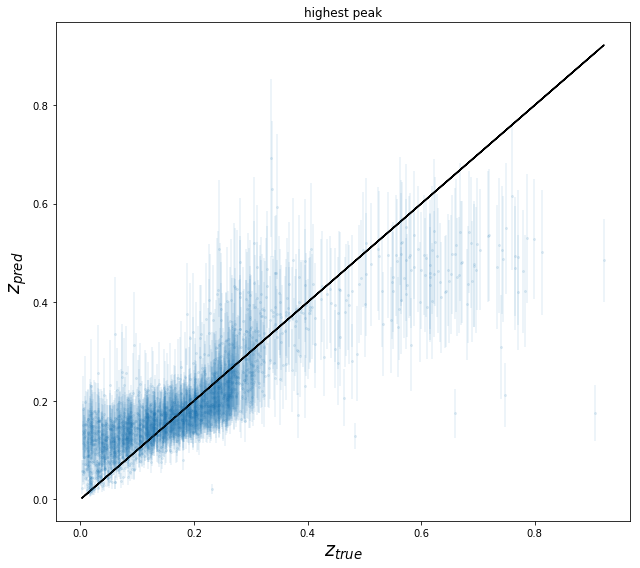

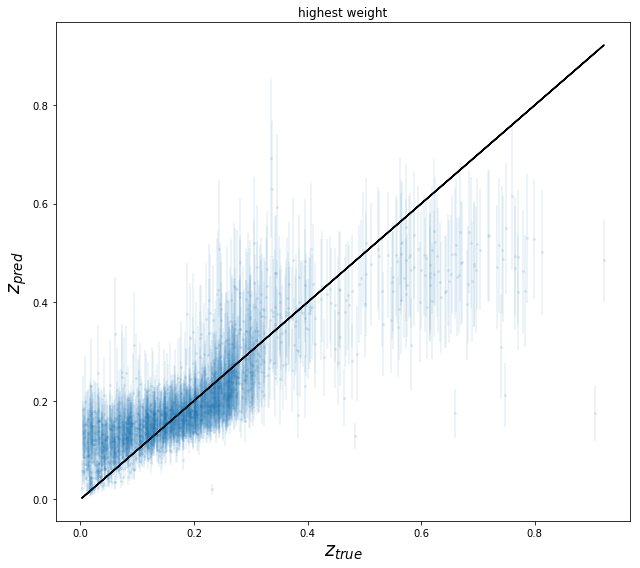

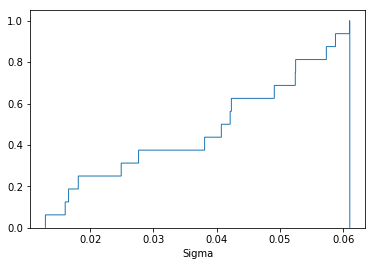

In [20]:
#### MODEL 1 ####

##load network
neural_network_t = hub.Module(save_mod)

##testing
test_weights, test_means, test_std = testing(X_test,y_test)

##plotting
plot_pred_mean(test_means,test_weights,test_std,ymax,ymin,y_test)
test_mean_diff, test_med_diff, test_std_diff, test_mean_sigma, test_med_sigma, test_std_sigma = per_stats(test_means,test_weights,test_std,ymax,ymin,y_test)
plot_pred_peak(test_means,test_weights,test_std,ymax,ymin,y_test)
plot_pred_weight(test_means,test_weights,test_std,ymax,ymin,y_test)
plot_cum_sigma(test_weights,test_std,ymax,ymin)



[462, 18, 81]
0
1
2


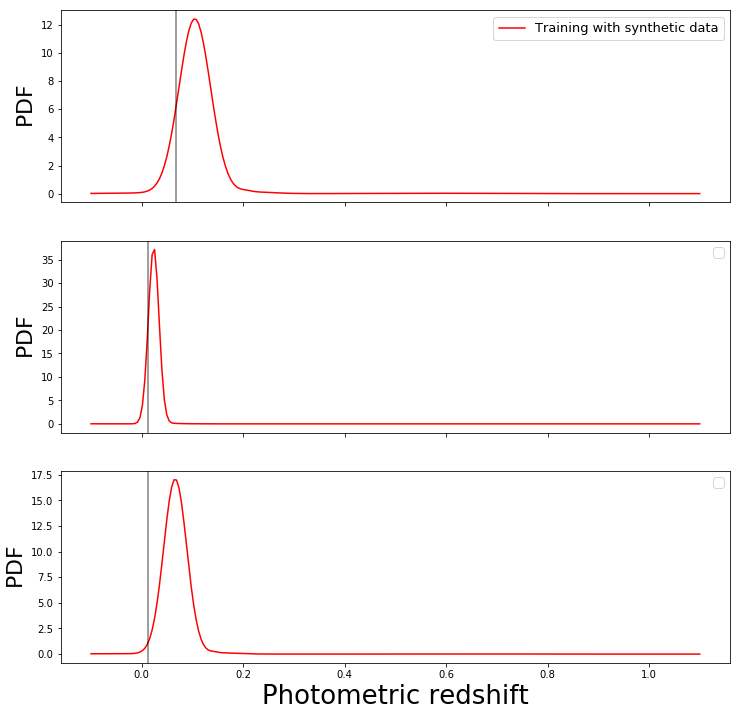

In [21]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', color = '', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """

  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
#       ax.plot(x, temp, label='Normal ' + str(i), alpha =0.6)
      ax.plot(x, temp, 'k--', alpha =0.9)

#       ax.plot(x, temp/final.max(), alpha =0.5)

  ax.plot(x, final,label=label, color = color)
#   ax.plot(x, final/final.max(), label=label, color = color)

    
  ax.legend(fontsize=13)
  return final

def plot_pdfs(pred_means,pred_weights,pred_std, y,num=4, label = '', color = '', train=False, comp = False):
    np.random.seed(12)

    if train:
        obj = np.random.randint(0,num_train-1,num)
    else:
        obj = np.random.randint(0,num_test-1,num)
#     obj = [462, 667, 81]
#     obj = [462, 102, 81]
    obj = [462, 18, 81]
    
    print(obj)

    allfs = []
    for i in range(len(obj)):
        print(i)
        if (i==0):
            fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = label, color = color, comp=comp)
        else: fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = '', color = color, comp=comp)

        axes[i].set_ylabel(r'${\rm PDF}$', fontsize = 22)
        allfs.append(fs)
        axes[i].axvline(x=y[obj][i], color='black', alpha=0.5)
        

    plt.xlabel('Photometric redshift', fontsize = 26)
    




## plotting pdfs
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(12, nrows*4), num='pdfs')
plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
# plot_pdfs(test_means_2,test_weights_2,test_std_2, y_test, num=nrows, label = 'Training with observational data', color = 'blue', train=False)

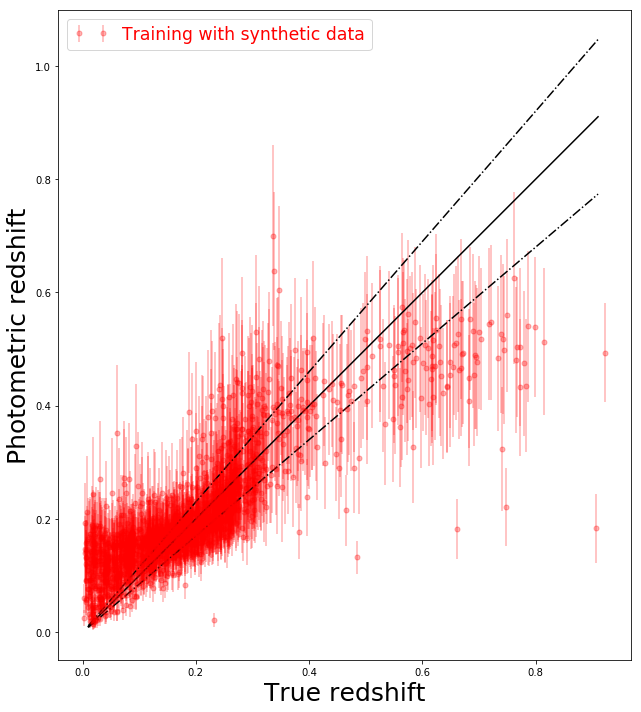

In [22]:
# fig = plt.figure(22)
y_pred = np.sum(test_means*test_weights, axis = 1)
y_pred_std = np.sum(test_std*test_weights, axis = 1)

## Overall mean --- weight * mean
ifPlotWeighted = True

if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10))

    
    plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
      ymin + y_pred_std), fmt='ro', ecolor='r', ms = 5, alpha = 0.3, label = 'Training with synthetic data')




line_limits = np.arange(1e-2, 1.0, 0.1)
plt.plot( line_limits, line_limits, 'k')
plt.plot( line_limits, 0.85*np.array(line_limits), 'k-.')
plt.plot( line_limits, 1.15*np.array(line_limits), 'k-.')

# plt.ylabel(r'$z_{\rm phot}$', fontsize=30)
# plt.xlabel(r'$z_{\rm spec}$', fontsize=30)
# plt.xscale('log')
# plt.yscale('log')

plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)
# plt.xlim(0.0, 1)
# plt.ylim(0.0, 1)

plt.legend(fontsize = 'large', markerscale=3., numpoints=3)
# plt.title('weight x mean')
plt.tight_layout()

plt.axes().set_aspect('equal')



leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()
